In [1]:
import argparse
import os

import seaborn as sns
import numpy as np

In [2]:
import sys
sys.argv = ['']


In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
load_path = ("../edbespoketart/trained_model/2023-11-15:13-32-46")

In [5]:
metrics = {}
for file in os.listdir(load_path):
    if ".npy" not in file:
        continue 

    metrics[file[:file.index(".")]] = np.load(os.path.join(load_path,file))


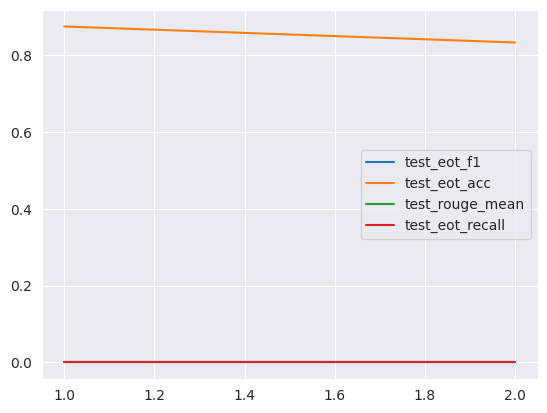

In [6]:
for key in metrics:
    if "test" in key and "loss" not in key and 'lr' not in key:
        ax = sns.lineplot(x=[i for i in range(1,1+len(metrics[key]))],
                     y=metrics[key], label=key)

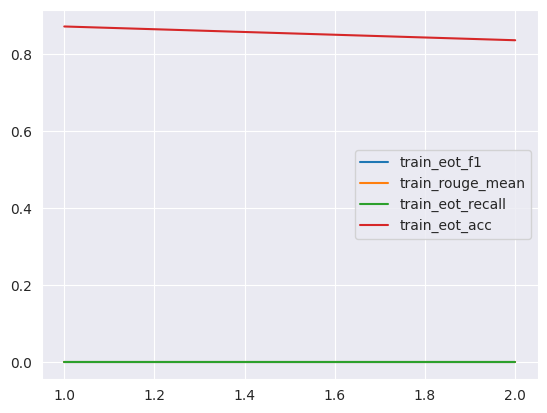

In [7]:
for key in metrics:
    if "train" in key and "loss" not in key and 'lr' not in key:
        ax = sns.lineplot(x=[i for i in range(1,1+len(metrics[key]))],
                          y=metrics[key], label=key)


<Axes: >

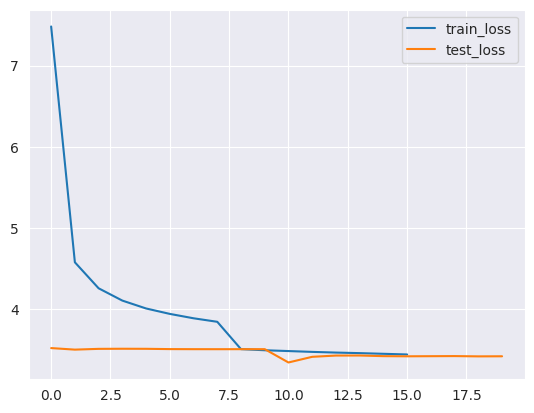

In [30]:
sns.lineplot(x=[i for i in range(1 + len(metrics["train_avg_loss"])//10)],
             y=[metrics["train_avg_loss"][m] for m in range(0, len(metrics["train_avg_loss"]), 10)], label="train_loss")
sns.lineplot(x=[i for i in range(len(metrics["test_avg_loss"]))],
             y=metrics["test_avg_loss"], label="test_loss")


In [29]:
len(metrics["train_avg_loss"])//10, len([metrics["train_avg_loss"][m] for m in range(0, len(metrics["train_avg_loss"]), 10)])


(15, 16)

In [18]:
from data.transcript_dm import TranscriptDataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from train import collate_fn, build_parser
import torch
from trainer import Trainer
from types import SimpleNamespace
import json 
import argparse
from model import EncoderDecoderBert
from train import get_latest_model



In [19]:
ts = TranscriptDataset(
        tokenizer=AutoTokenizer.from_pretrained("bert-base-uncased"), overwrite=False)
ts.setup()
dl = DataLoader(ts, batch_size=320, collate_fn=collate_fn)

In [20]:
load_path = "/home/seanleishman/BespokeTart/gbespoketart/trained_model/2023-11-13:19-40-23"

config = build_parser(parse_args=True)

with open(os.path.join(load_path, "config.json")) as f:
    new_config = SimpleNamespace(**json.load(f))
    for arg in vars(new_config):
        config.arg = getattr(new_config, arg)
config.device = "cuda" if torch.cuda.is_available() and (
        config.cuda == "true") else "cpu"

In [21]:
model = EncoderDecoderBert(
            bert_finetuning=False,
            config=config,
        )

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.2.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.7.crossattention.self.query.bias', 'bert.encoder.layer.8.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.self.key.weight', 'bert.encoder.layer.11.crossattention.self.query.weight', 'bert.encoder.layer.9.crossattention.output.dense.weight', 'bert.encoder.layer.2.crossattention.output.dense.weight', 'bert.encoder.layer.11.crossattention.self.query.bias', 'bert.encoder.layer.9.crossattention.output.dense.bias', 'bert.encoder.layer.4.cr

In [24]:
criterion = torch.nn.CrossEntropyLoss().to(config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

In [30]:
model 

EncoderDecoderBert(
  (encoder): BertGenerationEncoder(
    (embeddings): BertGenerationEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertGenerationLayer(
          (attention): BertGenerationAttention(
            (self): BertGenerationSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertGenerationSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [25]:
trainer = Trainer(model=model, criterion=criterion,
                          optimizer=optimizer, config=config,
                          load_from_checkpoint=get_latest_model(load_path))

Namespace(cuda='true', load_model='false', load_path='trained_model/', save_path='trained_model/', bert_type='bert', bert_finetuning='false', bert_pretraining='bert-base-uncased', epochs=10, batch_size=128, learning_rate=0.002, weight_decay=0.01, early_stop=5, evaluate='false', description='', loss_weight=1.355, output_window=5, context_window=2, max_prior_window=300, overwrite='false', dev_mode=False, arg='cuda', device='cuda')


RuntimeError: Error(s) in loading state_dict for EncoderDecoderBert:
	Missing key(s) in state_dict: "encoder.embeddings.word_embeddings.weight", "encoder.embeddings.position_embeddings.weight", "encoder.embeddings.LayerNorm.weight", "encoder.embeddings.LayerNorm.bias", "encoder.encoder.layer.0.attention.self.query.weight", "encoder.encoder.layer.0.attention.self.query.bias", "encoder.encoder.layer.0.attention.self.key.weight", "encoder.encoder.layer.0.attention.self.key.bias", "encoder.encoder.layer.0.attention.self.value.weight", "encoder.encoder.layer.0.attention.self.value.bias", "encoder.encoder.layer.0.attention.output.dense.weight", "encoder.encoder.layer.0.attention.output.dense.bias", "encoder.encoder.layer.0.attention.output.LayerNorm.weight", "encoder.encoder.layer.0.attention.output.LayerNorm.bias", "encoder.encoder.layer.0.intermediate.dense.weight", "encoder.encoder.layer.0.intermediate.dense.bias", "encoder.encoder.layer.0.output.dense.weight", "encoder.encoder.layer.0.output.dense.bias", "encoder.encoder.layer.0.output.LayerNorm.weight", "encoder.encoder.layer.0.output.LayerNorm.bias", "encoder.encoder.layer.1.attention.self.query.weight", "encoder.encoder.layer.1.attention.self.query.bias", "encoder.encoder.layer.1.attention.self.key.weight", "encoder.encoder.layer.1.attention.self.key.bias", "encoder.encoder.layer.1.attention.self.value.weight", "encoder.encoder.layer.1.attention.self.value.bias", "encoder.encoder.layer.1.attention.output.dense.weight", "encoder.encoder.layer.1.attention.output.dense.bias", "encoder.encoder.layer.1.attention.output.LayerNorm.weight", "encoder.encoder.layer.1.attention.output.LayerNorm.bias", "encoder.encoder.layer.1.intermediate.dense.weight", "encoder.encoder.layer.1.intermediate.dense.bias", "encoder.encoder.layer.1.output.dense.weight", "encoder.encoder.layer.1.output.dense.bias", "encoder.encoder.layer.1.output.LayerNorm.weight", "encoder.encoder.layer.1.output.LayerNorm.bias", "encoder.encoder.layer.2.attention.self.query.weight", "encoder.encoder.layer.2.attention.self.query.bias", "encoder.encoder.layer.2.attention.self.key.weight", "encoder.encoder.layer.2.attention.self.key.bias", "encoder.encoder.layer.2.attention.self.value.weight", "encoder.encoder.layer.2.attention.self.value.bias", "encoder.encoder.layer.2.attention.output.dense.weight", "encoder.encoder.layer.2.attention.output.dense.bias", "encoder.encoder.layer.2.attention.output.LayerNorm.weight", "encoder.encoder.layer.2.attention.output.LayerNorm.bias", "encoder.encoder.layer.2.intermediate.dense.weight", "encoder.encoder.layer.2.intermediate.dense.bias", "encoder.encoder.layer.2.output.dense.weight", "encoder.encoder.layer.2.output.dense.bias", "encoder.encoder.layer.2.output.LayerNorm.weight", "encoder.encoder.layer.2.output.LayerNorm.bias", "encoder.encoder.layer.3.attention.self.query.weight", "encoder.encoder.layer.3.attention.self.query.bias", "encoder.encoder.layer.3.attention.self.key.weight", "encoder.encoder.layer.3.attention.self.key.bias", "encoder.encoder.layer.3.attention.self.value.weight", "encoder.encoder.layer.3.attention.self.value.bias", "encoder.encoder.layer.3.attention.output.dense.weight", "encoder.encoder.layer.3.attention.output.dense.bias", "encoder.encoder.layer.3.attention.output.LayerNorm.weight", "encoder.encoder.layer.3.attention.output.LayerNorm.bias", "encoder.encoder.layer.3.intermediate.dense.weight", "encoder.encoder.layer.3.intermediate.dense.bias", "encoder.encoder.layer.3.output.dense.weight", "encoder.encoder.layer.3.output.dense.bias", "encoder.encoder.layer.3.output.LayerNorm.weight", "encoder.encoder.layer.3.output.LayerNorm.bias", "encoder.encoder.layer.4.attention.self.query.weight", "encoder.encoder.layer.4.attention.self.query.bias", "encoder.encoder.layer.4.attention.self.key.weight", "encoder.encoder.layer.4.attention.self.key.bias", "encoder.encoder.layer.4.attention.self.value.weight", "encoder.encoder.layer.4.attention.self.value.bias", "encoder.encoder.layer.4.attention.output.dense.weight", "encoder.encoder.layer.4.attention.output.dense.bias", "encoder.encoder.layer.4.attention.output.LayerNorm.weight", "encoder.encoder.layer.4.attention.output.LayerNorm.bias", "encoder.encoder.layer.4.intermediate.dense.weight", "encoder.encoder.layer.4.intermediate.dense.bias", "encoder.encoder.layer.4.output.dense.weight", "encoder.encoder.layer.4.output.dense.bias", "encoder.encoder.layer.4.output.LayerNorm.weight", "encoder.encoder.layer.4.output.LayerNorm.bias", "encoder.encoder.layer.5.attention.self.query.weight", "encoder.encoder.layer.5.attention.self.query.bias", "encoder.encoder.layer.5.attention.self.key.weight", "encoder.encoder.layer.5.attention.self.key.bias", "encoder.encoder.layer.5.attention.self.value.weight", "encoder.encoder.layer.5.attention.self.value.bias", "encoder.encoder.layer.5.attention.output.dense.weight", "encoder.encoder.layer.5.attention.output.dense.bias", "encoder.encoder.layer.5.attention.output.LayerNorm.weight", "encoder.encoder.layer.5.attention.output.LayerNorm.bias", "encoder.encoder.layer.5.intermediate.dense.weight", "encoder.encoder.layer.5.intermediate.dense.bias", "encoder.encoder.layer.5.output.dense.weight", "encoder.encoder.layer.5.output.dense.bias", "encoder.encoder.layer.5.output.LayerNorm.weight", "encoder.encoder.layer.5.output.LayerNorm.bias", "encoder.encoder.layer.6.attention.self.query.weight", "encoder.encoder.layer.6.attention.self.query.bias", "encoder.encoder.layer.6.attention.self.key.weight", "encoder.encoder.layer.6.attention.self.key.bias", "encoder.encoder.layer.6.attention.self.value.weight", "encoder.encoder.layer.6.attention.self.value.bias", "encoder.encoder.layer.6.attention.output.dense.weight", "encoder.encoder.layer.6.attention.output.dense.bias", "encoder.encoder.layer.6.attention.output.LayerNorm.weight", "encoder.encoder.layer.6.attention.output.LayerNorm.bias", "encoder.encoder.layer.6.intermediate.dense.weight", "encoder.encoder.layer.6.intermediate.dense.bias", "encoder.encoder.layer.6.output.dense.weight", "encoder.encoder.layer.6.output.dense.bias", "encoder.encoder.layer.6.output.LayerNorm.weight", "encoder.encoder.layer.6.output.LayerNorm.bias", "encoder.encoder.layer.7.attention.self.query.weight", "encoder.encoder.layer.7.attention.self.query.bias", "encoder.encoder.layer.7.attention.self.key.weight", "encoder.encoder.layer.7.attention.self.key.bias", "encoder.encoder.layer.7.attention.self.value.weight", "encoder.encoder.layer.7.attention.self.value.bias", "encoder.encoder.layer.7.attention.output.dense.weight", "encoder.encoder.layer.7.attention.output.dense.bias", "encoder.encoder.layer.7.attention.output.LayerNorm.weight", "encoder.encoder.layer.7.attention.output.LayerNorm.bias", "encoder.encoder.layer.7.intermediate.dense.weight", "encoder.encoder.layer.7.intermediate.dense.bias", "encoder.encoder.layer.7.output.dense.weight", "encoder.encoder.layer.7.output.dense.bias", "encoder.encoder.layer.7.output.LayerNorm.weight", "encoder.encoder.layer.7.output.LayerNorm.bias", "encoder.encoder.layer.8.attention.self.query.weight", "encoder.encoder.layer.8.attention.self.query.bias", "encoder.encoder.layer.8.attention.self.key.weight", "encoder.encoder.layer.8.attention.self.key.bias", "encoder.encoder.layer.8.attention.self.value.weight", "encoder.encoder.layer.8.attention.self.value.bias", "encoder.encoder.layer.8.attention.output.dense.weight", "encoder.encoder.layer.8.attention.output.dense.bias", "encoder.encoder.layer.8.attention.output.LayerNorm.weight", "encoder.encoder.layer.8.attention.output.LayerNorm.bias", "encoder.encoder.layer.8.intermediate.dense.weight", "encoder.encoder.layer.8.intermediate.dense.bias", "encoder.encoder.layer.8.output.dense.weight", "encoder.encoder.layer.8.output.dense.bias", "encoder.encoder.layer.8.output.LayerNorm.weight", "encoder.encoder.layer.8.output.LayerNorm.bias", "encoder.encoder.layer.9.attention.self.query.weight", "encoder.encoder.layer.9.attention.self.query.bias", "encoder.encoder.layer.9.attention.self.key.weight", "encoder.encoder.layer.9.attention.self.key.bias", "encoder.encoder.layer.9.attention.self.value.weight", "encoder.encoder.layer.9.attention.self.value.bias", "encoder.encoder.layer.9.attention.output.dense.weight", "encoder.encoder.layer.9.attention.output.dense.bias", "encoder.encoder.layer.9.attention.output.LayerNorm.weight", "encoder.encoder.layer.9.attention.output.LayerNorm.bias", "encoder.encoder.layer.9.intermediate.dense.weight", "encoder.encoder.layer.9.intermediate.dense.bias", "encoder.encoder.layer.9.output.dense.weight", "encoder.encoder.layer.9.output.dense.bias", "encoder.encoder.layer.9.output.LayerNorm.weight", "encoder.encoder.layer.9.output.LayerNorm.bias", "encoder.encoder.layer.10.attention.self.query.weight", "encoder.encoder.layer.10.attention.self.query.bias", "encoder.encoder.layer.10.attention.self.key.weight", "encoder.encoder.layer.10.attention.self.key.bias", "encoder.encoder.layer.10.attention.self.value.weight", "encoder.encoder.layer.10.attention.self.value.bias", "encoder.encoder.layer.10.attention.output.dense.weight", "encoder.encoder.layer.10.attention.output.dense.bias", "encoder.encoder.layer.10.attention.output.LayerNorm.weight", "encoder.encoder.layer.10.attention.output.LayerNorm.bias", "encoder.encoder.layer.10.intermediate.dense.weight", "encoder.encoder.layer.10.intermediate.dense.bias", "encoder.encoder.layer.10.output.dense.weight", "encoder.encoder.layer.10.output.dense.bias", "encoder.encoder.layer.10.output.LayerNorm.weight", "encoder.encoder.layer.10.output.LayerNorm.bias", "encoder.encoder.layer.11.attention.self.query.weight", "encoder.encoder.layer.11.attention.self.query.bias", "encoder.encoder.layer.11.attention.self.key.weight", "encoder.encoder.layer.11.attention.self.key.bias", "encoder.encoder.layer.11.attention.self.value.weight", "encoder.encoder.layer.11.attention.self.value.bias", "encoder.encoder.layer.11.attention.output.dense.weight", "encoder.encoder.layer.11.attention.output.dense.bias", "encoder.encoder.layer.11.attention.output.LayerNorm.weight", "encoder.encoder.layer.11.attention.output.LayerNorm.bias", "encoder.encoder.layer.11.intermediate.dense.weight", "encoder.encoder.layer.11.intermediate.dense.bias", "encoder.encoder.layer.11.output.dense.weight", "encoder.encoder.layer.11.output.dense.bias", "encoder.encoder.layer.11.output.LayerNorm.weight", "encoder.encoder.layer.11.output.LayerNorm.bias", "decoder.bert.embeddings.word_embeddings.weight", "decoder.bert.embeddings.position_embeddings.weight", "decoder.bert.embeddings.token_type_embeddings.weight", "decoder.bert.embeddings.LayerNorm.weight", "decoder.bert.embeddings.LayerNorm.bias", "decoder.bert.encoder.layer.0.attention.self.query.weight", "decoder.bert.encoder.layer.0.attention.self.query.bias", "decoder.bert.encoder.layer.0.attention.self.key.weight", "decoder.bert.encoder.layer.0.attention.self.key.bias", "decoder.bert.encoder.layer.0.attention.self.value.weight", "decoder.bert.encoder.layer.0.attention.self.value.bias", "decoder.bert.encoder.layer.0.attention.output.dense.weight", "decoder.bert.encoder.layer.0.attention.output.dense.bias", "decoder.bert.encoder.layer.0.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.0.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.0.crossattention.self.query.weight", "decoder.bert.encoder.layer.0.crossattention.self.query.bias", "decoder.bert.encoder.layer.0.crossattention.self.key.weight", "decoder.bert.encoder.layer.0.crossattention.self.key.bias", "decoder.bert.encoder.layer.0.crossattention.self.value.weight", "decoder.bert.encoder.layer.0.crossattention.self.value.bias", "decoder.bert.encoder.layer.0.crossattention.output.dense.weight", "decoder.bert.encoder.layer.0.crossattention.output.dense.bias", "decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.0.intermediate.dense.weight", "decoder.bert.encoder.layer.0.intermediate.dense.bias", "decoder.bert.encoder.layer.0.output.dense.weight", "decoder.bert.encoder.layer.0.output.dense.bias", "decoder.bert.encoder.layer.0.output.LayerNorm.weight", "decoder.bert.encoder.layer.0.output.LayerNorm.bias", "decoder.bert.encoder.layer.1.attention.self.query.weight", "decoder.bert.encoder.layer.1.attention.self.query.bias", "decoder.bert.encoder.layer.1.attention.self.key.weight", "decoder.bert.encoder.layer.1.attention.self.key.bias", "decoder.bert.encoder.layer.1.attention.self.value.weight", "decoder.bert.encoder.layer.1.attention.self.value.bias", "decoder.bert.encoder.layer.1.attention.output.dense.weight", "decoder.bert.encoder.layer.1.attention.output.dense.bias", "decoder.bert.encoder.layer.1.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.1.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.1.crossattention.self.query.weight", "decoder.bert.encoder.layer.1.crossattention.self.query.bias", "decoder.bert.encoder.layer.1.crossattention.self.key.weight", "decoder.bert.encoder.layer.1.crossattention.self.key.bias", "decoder.bert.encoder.layer.1.crossattention.self.value.weight", "decoder.bert.encoder.layer.1.crossattention.self.value.bias", "decoder.bert.encoder.layer.1.crossattention.output.dense.weight", "decoder.bert.encoder.layer.1.crossattention.output.dense.bias", "decoder.bert.encoder.layer.1.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.1.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.1.intermediate.dense.weight", "decoder.bert.encoder.layer.1.intermediate.dense.bias", "decoder.bert.encoder.layer.1.output.dense.weight", "decoder.bert.encoder.layer.1.output.dense.bias", "decoder.bert.encoder.layer.1.output.LayerNorm.weight", "decoder.bert.encoder.layer.1.output.LayerNorm.bias", "decoder.bert.encoder.layer.2.attention.self.query.weight", "decoder.bert.encoder.layer.2.attention.self.query.bias", "decoder.bert.encoder.layer.2.attention.self.key.weight", "decoder.bert.encoder.layer.2.attention.self.key.bias", "decoder.bert.encoder.layer.2.attention.self.value.weight", "decoder.bert.encoder.layer.2.attention.self.value.bias", "decoder.bert.encoder.layer.2.attention.output.dense.weight", "decoder.bert.encoder.layer.2.attention.output.dense.bias", "decoder.bert.encoder.layer.2.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.2.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.2.crossattention.self.query.weight", "decoder.bert.encoder.layer.2.crossattention.self.query.bias", "decoder.bert.encoder.layer.2.crossattention.self.key.weight", "decoder.bert.encoder.layer.2.crossattention.self.key.bias", "decoder.bert.encoder.layer.2.crossattention.self.value.weight", "decoder.bert.encoder.layer.2.crossattention.self.value.bias", "decoder.bert.encoder.layer.2.crossattention.output.dense.weight", "decoder.bert.encoder.layer.2.crossattention.output.dense.bias", "decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.2.intermediate.dense.weight", "decoder.bert.encoder.layer.2.intermediate.dense.bias", "decoder.bert.encoder.layer.2.output.dense.weight", "decoder.bert.encoder.layer.2.output.dense.bias", "decoder.bert.encoder.layer.2.output.LayerNorm.weight", "decoder.bert.encoder.layer.2.output.LayerNorm.bias", "decoder.bert.encoder.layer.3.attention.self.query.weight", "decoder.bert.encoder.layer.3.attention.self.query.bias", "decoder.bert.encoder.layer.3.attention.self.key.weight", "decoder.bert.encoder.layer.3.attention.self.key.bias", "decoder.bert.encoder.layer.3.attention.self.value.weight", "decoder.bert.encoder.layer.3.attention.self.value.bias", "decoder.bert.encoder.layer.3.attention.output.dense.weight", "decoder.bert.encoder.layer.3.attention.output.dense.bias", "decoder.bert.encoder.layer.3.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.3.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.3.crossattention.self.query.weight", "decoder.bert.encoder.layer.3.crossattention.self.query.bias", "decoder.bert.encoder.layer.3.crossattention.self.key.weight", "decoder.bert.encoder.layer.3.crossattention.self.key.bias", "decoder.bert.encoder.layer.3.crossattention.self.value.weight", "decoder.bert.encoder.layer.3.crossattention.self.value.bias", "decoder.bert.encoder.layer.3.crossattention.output.dense.weight", "decoder.bert.encoder.layer.3.crossattention.output.dense.bias", "decoder.bert.encoder.layer.3.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.3.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.3.intermediate.dense.weight", "decoder.bert.encoder.layer.3.intermediate.dense.bias", "decoder.bert.encoder.layer.3.output.dense.weight", "decoder.bert.encoder.layer.3.output.dense.bias", "decoder.bert.encoder.layer.3.output.LayerNorm.weight", "decoder.bert.encoder.layer.3.output.LayerNorm.bias", "decoder.bert.encoder.layer.4.attention.self.query.weight", "decoder.bert.encoder.layer.4.attention.self.query.bias", "decoder.bert.encoder.layer.4.attention.self.key.weight", "decoder.bert.encoder.layer.4.attention.self.key.bias", "decoder.bert.encoder.layer.4.attention.self.value.weight", "decoder.bert.encoder.layer.4.attention.self.value.bias", "decoder.bert.encoder.layer.4.attention.output.dense.weight", "decoder.bert.encoder.layer.4.attention.output.dense.bias", "decoder.bert.encoder.layer.4.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.4.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.4.crossattention.self.query.weight", "decoder.bert.encoder.layer.4.crossattention.self.query.bias", "decoder.bert.encoder.layer.4.crossattention.self.key.weight", "decoder.bert.encoder.layer.4.crossattention.self.key.bias", "decoder.bert.encoder.layer.4.crossattention.self.value.weight", "decoder.bert.encoder.layer.4.crossattention.self.value.bias", "decoder.bert.encoder.layer.4.crossattention.output.dense.weight", "decoder.bert.encoder.layer.4.crossattention.output.dense.bias", "decoder.bert.encoder.layer.4.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.4.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.4.intermediate.dense.weight", "decoder.bert.encoder.layer.4.intermediate.dense.bias", "decoder.bert.encoder.layer.4.output.dense.weight", "decoder.bert.encoder.layer.4.output.dense.bias", "decoder.bert.encoder.layer.4.output.LayerNorm.weight", "decoder.bert.encoder.layer.4.output.LayerNorm.bias", "decoder.bert.encoder.layer.5.attention.self.query.weight", "decoder.bert.encoder.layer.5.attention.self.query.bias", "decoder.bert.encoder.layer.5.attention.self.key.weight", "decoder.bert.encoder.layer.5.attention.self.key.bias", "decoder.bert.encoder.layer.5.attention.self.value.weight", "decoder.bert.encoder.layer.5.attention.self.value.bias", "decoder.bert.encoder.layer.5.attention.output.dense.weight", "decoder.bert.encoder.layer.5.attention.output.dense.bias", "decoder.bert.encoder.layer.5.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.5.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.5.crossattention.self.query.weight", "decoder.bert.encoder.layer.5.crossattention.self.query.bias", "decoder.bert.encoder.layer.5.crossattention.self.key.weight", "decoder.bert.encoder.layer.5.crossattention.self.key.bias", "decoder.bert.encoder.layer.5.crossattention.self.value.weight", "decoder.bert.encoder.layer.5.crossattention.self.value.bias", "decoder.bert.encoder.layer.5.crossattention.output.dense.weight", "decoder.bert.encoder.layer.5.crossattention.output.dense.bias", "decoder.bert.encoder.layer.5.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.5.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.5.intermediate.dense.weight", "decoder.bert.encoder.layer.5.intermediate.dense.bias", "decoder.bert.encoder.layer.5.output.dense.weight", "decoder.bert.encoder.layer.5.output.dense.bias", "decoder.bert.encoder.layer.5.output.LayerNorm.weight", "decoder.bert.encoder.layer.5.output.LayerNorm.bias", "decoder.bert.encoder.layer.6.attention.self.query.weight", "decoder.bert.encoder.layer.6.attention.self.query.bias", "decoder.bert.encoder.layer.6.attention.self.key.weight", "decoder.bert.encoder.layer.6.attention.self.key.bias", "decoder.bert.encoder.layer.6.attention.self.value.weight", "decoder.bert.encoder.layer.6.attention.self.value.bias", "decoder.bert.encoder.layer.6.attention.output.dense.weight", "decoder.bert.encoder.layer.6.attention.output.dense.bias", "decoder.bert.encoder.layer.6.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.6.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.6.crossattention.self.query.weight", "decoder.bert.encoder.layer.6.crossattention.self.query.bias", "decoder.bert.encoder.layer.6.crossattention.self.key.weight", "decoder.bert.encoder.layer.6.crossattention.self.key.bias", "decoder.bert.encoder.layer.6.crossattention.self.value.weight", "decoder.bert.encoder.layer.6.crossattention.self.value.bias", "decoder.bert.encoder.layer.6.crossattention.output.dense.weight", "decoder.bert.encoder.layer.6.crossattention.output.dense.bias", "decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.6.intermediate.dense.weight", "decoder.bert.encoder.layer.6.intermediate.dense.bias", "decoder.bert.encoder.layer.6.output.dense.weight", "decoder.bert.encoder.layer.6.output.dense.bias", "decoder.bert.encoder.layer.6.output.LayerNorm.weight", "decoder.bert.encoder.layer.6.output.LayerNorm.bias", "decoder.bert.encoder.layer.7.attention.self.query.weight", "decoder.bert.encoder.layer.7.attention.self.query.bias", "decoder.bert.encoder.layer.7.attention.self.key.weight", "decoder.bert.encoder.layer.7.attention.self.key.bias", "decoder.bert.encoder.layer.7.attention.self.value.weight", "decoder.bert.encoder.layer.7.attention.self.value.bias", "decoder.bert.encoder.layer.7.attention.output.dense.weight", "decoder.bert.encoder.layer.7.attention.output.dense.bias", "decoder.bert.encoder.layer.7.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.7.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.7.crossattention.self.query.weight", "decoder.bert.encoder.layer.7.crossattention.self.query.bias", "decoder.bert.encoder.layer.7.crossattention.self.key.weight", "decoder.bert.encoder.layer.7.crossattention.self.key.bias", "decoder.bert.encoder.layer.7.crossattention.self.value.weight", "decoder.bert.encoder.layer.7.crossattention.self.value.bias", "decoder.bert.encoder.layer.7.crossattention.output.dense.weight", "decoder.bert.encoder.layer.7.crossattention.output.dense.bias", "decoder.bert.encoder.layer.7.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.7.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.7.intermediate.dense.weight", "decoder.bert.encoder.layer.7.intermediate.dense.bias", "decoder.bert.encoder.layer.7.output.dense.weight", "decoder.bert.encoder.layer.7.output.dense.bias", "decoder.bert.encoder.layer.7.output.LayerNorm.weight", "decoder.bert.encoder.layer.7.output.LayerNorm.bias", "decoder.bert.encoder.layer.8.attention.self.query.weight", "decoder.bert.encoder.layer.8.attention.self.query.bias", "decoder.bert.encoder.layer.8.attention.self.key.weight", "decoder.bert.encoder.layer.8.attention.self.key.bias", "decoder.bert.encoder.layer.8.attention.self.value.weight", "decoder.bert.encoder.layer.8.attention.self.value.bias", "decoder.bert.encoder.layer.8.attention.output.dense.weight", "decoder.bert.encoder.layer.8.attention.output.dense.bias", "decoder.bert.encoder.layer.8.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.8.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.8.crossattention.self.query.weight", "decoder.bert.encoder.layer.8.crossattention.self.query.bias", "decoder.bert.encoder.layer.8.crossattention.self.key.weight", "decoder.bert.encoder.layer.8.crossattention.self.key.bias", "decoder.bert.encoder.layer.8.crossattention.self.value.weight", "decoder.bert.encoder.layer.8.crossattention.self.value.bias", "decoder.bert.encoder.layer.8.crossattention.output.dense.weight", "decoder.bert.encoder.layer.8.crossattention.output.dense.bias", "decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.8.intermediate.dense.weight", "decoder.bert.encoder.layer.8.intermediate.dense.bias", "decoder.bert.encoder.layer.8.output.dense.weight", "decoder.bert.encoder.layer.8.output.dense.bias", "decoder.bert.encoder.layer.8.output.LayerNorm.weight", "decoder.bert.encoder.layer.8.output.LayerNorm.bias", "decoder.bert.encoder.layer.9.attention.self.query.weight", "decoder.bert.encoder.layer.9.attention.self.query.bias", "decoder.bert.encoder.layer.9.attention.self.key.weight", "decoder.bert.encoder.layer.9.attention.self.key.bias", "decoder.bert.encoder.layer.9.attention.self.value.weight", "decoder.bert.encoder.layer.9.attention.self.value.bias", "decoder.bert.encoder.layer.9.attention.output.dense.weight", "decoder.bert.encoder.layer.9.attention.output.dense.bias", "decoder.bert.encoder.layer.9.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.9.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.9.crossattention.self.query.weight", "decoder.bert.encoder.layer.9.crossattention.self.query.bias", "decoder.bert.encoder.layer.9.crossattention.self.key.weight", "decoder.bert.encoder.layer.9.crossattention.self.key.bias", "decoder.bert.encoder.layer.9.crossattention.self.value.weight", "decoder.bert.encoder.layer.9.crossattention.self.value.bias", "decoder.bert.encoder.layer.9.crossattention.output.dense.weight", "decoder.bert.encoder.layer.9.crossattention.output.dense.bias", "decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.9.intermediate.dense.weight", "decoder.bert.encoder.layer.9.intermediate.dense.bias", "decoder.bert.encoder.layer.9.output.dense.weight", "decoder.bert.encoder.layer.9.output.dense.bias", "decoder.bert.encoder.layer.9.output.LayerNorm.weight", "decoder.bert.encoder.layer.9.output.LayerNorm.bias", "decoder.bert.encoder.layer.10.attention.self.query.weight", "decoder.bert.encoder.layer.10.attention.self.query.bias", "decoder.bert.encoder.layer.10.attention.self.key.weight", "decoder.bert.encoder.layer.10.attention.self.key.bias", "decoder.bert.encoder.layer.10.attention.self.value.weight", "decoder.bert.encoder.layer.10.attention.self.value.bias", "decoder.bert.encoder.layer.10.attention.output.dense.weight", "decoder.bert.encoder.layer.10.attention.output.dense.bias", "decoder.bert.encoder.layer.10.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.10.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.10.crossattention.self.query.weight", "decoder.bert.encoder.layer.10.crossattention.self.query.bias", "decoder.bert.encoder.layer.10.crossattention.self.key.weight", "decoder.bert.encoder.layer.10.crossattention.self.key.bias", "decoder.bert.encoder.layer.10.crossattention.self.value.weight", "decoder.bert.encoder.layer.10.crossattention.self.value.bias", "decoder.bert.encoder.layer.10.crossattention.output.dense.weight", "decoder.bert.encoder.layer.10.crossattention.output.dense.bias", "decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.10.intermediate.dense.weight", "decoder.bert.encoder.layer.10.intermediate.dense.bias", "decoder.bert.encoder.layer.10.output.dense.weight", "decoder.bert.encoder.layer.10.output.dense.bias", "decoder.bert.encoder.layer.10.output.LayerNorm.weight", "decoder.bert.encoder.layer.10.output.LayerNorm.bias", "decoder.bert.encoder.layer.11.attention.self.query.weight", "decoder.bert.encoder.layer.11.attention.self.query.bias", "decoder.bert.encoder.layer.11.attention.self.key.weight", "decoder.bert.encoder.layer.11.attention.self.key.bias", "decoder.bert.encoder.layer.11.attention.self.value.weight", "decoder.bert.encoder.layer.11.attention.self.value.bias", "decoder.bert.encoder.layer.11.attention.output.dense.weight", "decoder.bert.encoder.layer.11.attention.output.dense.bias", "decoder.bert.encoder.layer.11.attention.output.LayerNorm.weight", "decoder.bert.encoder.layer.11.attention.output.LayerNorm.bias", "decoder.bert.encoder.layer.11.crossattention.self.query.weight", "decoder.bert.encoder.layer.11.crossattention.self.query.bias", "decoder.bert.encoder.layer.11.crossattention.self.key.weight", "decoder.bert.encoder.layer.11.crossattention.self.key.bias", "decoder.bert.encoder.layer.11.crossattention.self.value.weight", "decoder.bert.encoder.layer.11.crossattention.self.value.bias", "decoder.bert.encoder.layer.11.crossattention.output.dense.weight", "decoder.bert.encoder.layer.11.crossattention.output.dense.bias", "decoder.bert.encoder.layer.11.crossattention.output.LayerNorm.weight", "decoder.bert.encoder.layer.11.crossattention.output.LayerNorm.bias", "decoder.bert.encoder.layer.11.intermediate.dense.weight", "decoder.bert.encoder.layer.11.intermediate.dense.bias", "decoder.bert.encoder.layer.11.output.dense.weight", "decoder.bert.encoder.layer.11.output.dense.bias", "decoder.bert.encoder.layer.11.output.LayerNorm.weight", "decoder.bert.encoder.layer.11.output.LayerNorm.bias", "decoder.cls.predictions.bias", "decoder.cls.predictions.transform.dense.weight", "decoder.cls.predictions.transform.dense.bias", "decoder.cls.predictions.transform.LayerNorm.weight", "decoder.cls.predictions.transform.LayerNorm.bias", "decoder.cls.predictions.decoder.weight", "decoder.cls.predictions.decoder.bias", "bertgeneration.encoder.embeddings.word_embeddings.weight", "bertgeneration.encoder.embeddings.position_embeddings.weight", "bertgeneration.encoder.embeddings.LayerNorm.weight", "bertgeneration.encoder.embeddings.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.0.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.0.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.0.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.0.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.0.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.0.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.0.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.0.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.0.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.0.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.0.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.0.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.0.output.dense.weight", "bertgeneration.encoder.encoder.layer.0.output.dense.bias", "bertgeneration.encoder.encoder.layer.0.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.0.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.1.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.1.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.1.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.1.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.1.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.1.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.1.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.1.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.1.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.1.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.1.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.1.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.1.output.dense.weight", "bertgeneration.encoder.encoder.layer.1.output.dense.bias", "bertgeneration.encoder.encoder.layer.1.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.1.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.2.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.2.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.2.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.2.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.2.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.2.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.2.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.2.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.2.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.2.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.2.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.2.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.2.output.dense.weight", "bertgeneration.encoder.encoder.layer.2.output.dense.bias", "bertgeneration.encoder.encoder.layer.2.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.2.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.3.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.3.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.3.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.3.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.3.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.3.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.3.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.3.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.3.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.3.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.3.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.3.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.3.output.dense.weight", "bertgeneration.encoder.encoder.layer.3.output.dense.bias", "bertgeneration.encoder.encoder.layer.3.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.3.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.4.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.4.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.4.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.4.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.4.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.4.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.4.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.4.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.4.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.4.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.4.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.4.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.4.output.dense.weight", "bertgeneration.encoder.encoder.layer.4.output.dense.bias", "bertgeneration.encoder.encoder.layer.4.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.4.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.5.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.5.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.5.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.5.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.5.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.5.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.5.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.5.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.5.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.5.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.5.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.5.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.5.output.dense.weight", "bertgeneration.encoder.encoder.layer.5.output.dense.bias", "bertgeneration.encoder.encoder.layer.5.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.5.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.6.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.6.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.6.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.6.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.6.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.6.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.6.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.6.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.6.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.6.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.6.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.6.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.6.output.dense.weight", "bertgeneration.encoder.encoder.layer.6.output.dense.bias", "bertgeneration.encoder.encoder.layer.6.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.6.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.7.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.7.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.7.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.7.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.7.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.7.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.7.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.7.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.7.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.7.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.7.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.7.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.7.output.dense.weight", "bertgeneration.encoder.encoder.layer.7.output.dense.bias", "bertgeneration.encoder.encoder.layer.7.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.7.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.8.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.8.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.8.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.8.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.8.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.8.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.8.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.8.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.8.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.8.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.8.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.8.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.8.output.dense.weight", "bertgeneration.encoder.encoder.layer.8.output.dense.bias", "bertgeneration.encoder.encoder.layer.8.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.8.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.9.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.9.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.9.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.9.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.9.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.9.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.9.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.9.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.9.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.9.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.9.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.9.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.9.output.dense.weight", "bertgeneration.encoder.encoder.layer.9.output.dense.bias", "bertgeneration.encoder.encoder.layer.9.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.9.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.10.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.10.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.10.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.10.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.10.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.10.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.10.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.10.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.10.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.10.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.10.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.10.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.10.output.dense.weight", "bertgeneration.encoder.encoder.layer.10.output.dense.bias", "bertgeneration.encoder.encoder.layer.10.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.10.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.11.attention.self.query.weight", "bertgeneration.encoder.encoder.layer.11.attention.self.query.bias", "bertgeneration.encoder.encoder.layer.11.attention.self.key.weight", "bertgeneration.encoder.encoder.layer.11.attention.self.key.bias", "bertgeneration.encoder.encoder.layer.11.attention.self.value.weight", "bertgeneration.encoder.encoder.layer.11.attention.self.value.bias", "bertgeneration.encoder.encoder.layer.11.attention.output.dense.weight", "bertgeneration.encoder.encoder.layer.11.attention.output.dense.bias", "bertgeneration.encoder.encoder.layer.11.attention.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.11.attention.output.LayerNorm.bias", "bertgeneration.encoder.encoder.layer.11.intermediate.dense.weight", "bertgeneration.encoder.encoder.layer.11.intermediate.dense.bias", "bertgeneration.encoder.encoder.layer.11.output.dense.weight", "bertgeneration.encoder.encoder.layer.11.output.dense.bias", "bertgeneration.encoder.encoder.layer.11.output.LayerNorm.weight", "bertgeneration.encoder.encoder.layer.11.output.LayerNorm.bias", "bertgeneration.decoder.bert.embeddings.word_embeddings.weight", "bertgeneration.decoder.bert.embeddings.position_embeddings.weight", "bertgeneration.decoder.bert.embeddings.token_type_embeddings.weight", "bertgeneration.decoder.bert.embeddings.LayerNorm.weight", "bertgeneration.decoder.bert.embeddings.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.0.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.0.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.0.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.0.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.0.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.0.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.0.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.0.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.0.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.0.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.0.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.0.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.0.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.0.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.0.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.0.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.1.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.1.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.1.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.1.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.1.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.1.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.1.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.1.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.1.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.1.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.1.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.1.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.1.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.1.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.1.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.1.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.1.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.2.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.2.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.2.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.2.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.2.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.2.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.2.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.2.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.2.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.2.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.2.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.2.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.2.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.2.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.2.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.2.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.3.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.3.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.3.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.3.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.3.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.3.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.3.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.3.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.3.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.3.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.3.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.3.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.3.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.3.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.3.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.3.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.3.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.4.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.4.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.4.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.4.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.4.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.4.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.4.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.4.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.4.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.4.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.4.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.4.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.4.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.4.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.4.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.4.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.4.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.5.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.5.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.5.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.5.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.5.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.5.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.5.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.5.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.5.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.5.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.5.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.5.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.5.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.5.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.5.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.5.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.5.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.6.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.6.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.6.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.6.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.6.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.6.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.6.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.6.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.6.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.6.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.6.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.6.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.6.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.6.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.6.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.6.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.6.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.7.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.7.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.7.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.7.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.7.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.7.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.7.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.7.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.7.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.7.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.7.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.7.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.7.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.7.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.7.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.7.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.7.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.8.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.8.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.8.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.8.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.8.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.8.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.8.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.8.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.8.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.8.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.8.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.8.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.8.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.8.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.8.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.8.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.8.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.9.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.9.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.9.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.9.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.9.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.9.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.9.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.9.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.9.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.9.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.9.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.9.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.9.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.9.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.9.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.9.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.9.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.10.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.10.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.10.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.10.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.10.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.10.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.10.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.10.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.10.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.10.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.10.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.10.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.10.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.10.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.10.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.10.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.10.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.11.attention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.11.attention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.11.attention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.11.attention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.11.attention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.11.attention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.11.attention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.11.attention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.11.attention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.11.attention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.self.query.weight", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.self.query.bias", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.self.key.weight", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.self.key.bias", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.self.value.weight", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.self.value.bias", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.11.crossattention.output.LayerNorm.bias", "bertgeneration.decoder.bert.encoder.layer.11.intermediate.dense.weight", "bertgeneration.decoder.bert.encoder.layer.11.intermediate.dense.bias", "bertgeneration.decoder.bert.encoder.layer.11.output.dense.weight", "bertgeneration.decoder.bert.encoder.layer.11.output.dense.bias", "bertgeneration.decoder.bert.encoder.layer.11.output.LayerNorm.weight", "bertgeneration.decoder.bert.encoder.layer.11.output.LayerNorm.bias", "bertgeneration.decoder.cls.predictions.bias", "bertgeneration.decoder.cls.predictions.transform.dense.weight", "bertgeneration.decoder.cls.predictions.transform.dense.bias", "bertgeneration.decoder.cls.predictions.transform.LayerNorm.weight", "bertgeneration.decoder.cls.predictions.transform.LayerNorm.bias", "bertgeneration.decoder.cls.predictions.decoder.weight", "bertgeneration.decoder.cls.predictions.decoder.bias". 
	Unexpected key(s) in state_dict: "bertlmhead.bert.embeddings.word_embeddings.weight", "bertlmhead.bert.embeddings.position_embeddings.weight", "bertlmhead.bert.embeddings.token_type_embeddings.weight", "bertlmhead.bert.embeddings.LayerNorm.weight", "bertlmhead.bert.embeddings.LayerNorm.bias", "bertlmhead.bert.encoder.layer.0.attention.self.query.weight", "bertlmhead.bert.encoder.layer.0.attention.self.query.bias", "bertlmhead.bert.encoder.layer.0.attention.self.key.weight", "bertlmhead.bert.encoder.layer.0.attention.self.key.bias", "bertlmhead.bert.encoder.layer.0.attention.self.value.weight", "bertlmhead.bert.encoder.layer.0.attention.self.value.bias", "bertlmhead.bert.encoder.layer.0.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.0.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.0.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.0.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.0.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.0.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.0.output.dense.weight", "bertlmhead.bert.encoder.layer.0.output.dense.bias", "bertlmhead.bert.encoder.layer.0.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.0.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.1.attention.self.query.weight", "bertlmhead.bert.encoder.layer.1.attention.self.query.bias", "bertlmhead.bert.encoder.layer.1.attention.self.key.weight", "bertlmhead.bert.encoder.layer.1.attention.self.key.bias", "bertlmhead.bert.encoder.layer.1.attention.self.value.weight", "bertlmhead.bert.encoder.layer.1.attention.self.value.bias", "bertlmhead.bert.encoder.layer.1.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.1.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.1.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.1.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.1.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.1.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.1.output.dense.weight", "bertlmhead.bert.encoder.layer.1.output.dense.bias", "bertlmhead.bert.encoder.layer.1.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.1.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.2.attention.self.query.weight", "bertlmhead.bert.encoder.layer.2.attention.self.query.bias", "bertlmhead.bert.encoder.layer.2.attention.self.key.weight", "bertlmhead.bert.encoder.layer.2.attention.self.key.bias", "bertlmhead.bert.encoder.layer.2.attention.self.value.weight", "bertlmhead.bert.encoder.layer.2.attention.self.value.bias", "bertlmhead.bert.encoder.layer.2.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.2.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.2.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.2.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.2.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.2.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.2.output.dense.weight", "bertlmhead.bert.encoder.layer.2.output.dense.bias", "bertlmhead.bert.encoder.layer.2.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.2.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.3.attention.self.query.weight", "bertlmhead.bert.encoder.layer.3.attention.self.query.bias", "bertlmhead.bert.encoder.layer.3.attention.self.key.weight", "bertlmhead.bert.encoder.layer.3.attention.self.key.bias", "bertlmhead.bert.encoder.layer.3.attention.self.value.weight", "bertlmhead.bert.encoder.layer.3.attention.self.value.bias", "bertlmhead.bert.encoder.layer.3.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.3.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.3.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.3.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.3.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.3.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.3.output.dense.weight", "bertlmhead.bert.encoder.layer.3.output.dense.bias", "bertlmhead.bert.encoder.layer.3.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.3.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.4.attention.self.query.weight", "bertlmhead.bert.encoder.layer.4.attention.self.query.bias", "bertlmhead.bert.encoder.layer.4.attention.self.key.weight", "bertlmhead.bert.encoder.layer.4.attention.self.key.bias", "bertlmhead.bert.encoder.layer.4.attention.self.value.weight", "bertlmhead.bert.encoder.layer.4.attention.self.value.bias", "bertlmhead.bert.encoder.layer.4.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.4.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.4.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.4.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.4.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.4.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.4.output.dense.weight", "bertlmhead.bert.encoder.layer.4.output.dense.bias", "bertlmhead.bert.encoder.layer.4.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.4.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.5.attention.self.query.weight", "bertlmhead.bert.encoder.layer.5.attention.self.query.bias", "bertlmhead.bert.encoder.layer.5.attention.self.key.weight", "bertlmhead.bert.encoder.layer.5.attention.self.key.bias", "bertlmhead.bert.encoder.layer.5.attention.self.value.weight", "bertlmhead.bert.encoder.layer.5.attention.self.value.bias", "bertlmhead.bert.encoder.layer.5.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.5.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.5.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.5.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.5.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.5.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.5.output.dense.weight", "bertlmhead.bert.encoder.layer.5.output.dense.bias", "bertlmhead.bert.encoder.layer.5.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.5.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.6.attention.self.query.weight", "bertlmhead.bert.encoder.layer.6.attention.self.query.bias", "bertlmhead.bert.encoder.layer.6.attention.self.key.weight", "bertlmhead.bert.encoder.layer.6.attention.self.key.bias", "bertlmhead.bert.encoder.layer.6.attention.self.value.weight", "bertlmhead.bert.encoder.layer.6.attention.self.value.bias", "bertlmhead.bert.encoder.layer.6.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.6.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.6.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.6.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.6.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.6.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.6.output.dense.weight", "bertlmhead.bert.encoder.layer.6.output.dense.bias", "bertlmhead.bert.encoder.layer.6.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.6.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.7.attention.self.query.weight", "bertlmhead.bert.encoder.layer.7.attention.self.query.bias", "bertlmhead.bert.encoder.layer.7.attention.self.key.weight", "bertlmhead.bert.encoder.layer.7.attention.self.key.bias", "bertlmhead.bert.encoder.layer.7.attention.self.value.weight", "bertlmhead.bert.encoder.layer.7.attention.self.value.bias", "bertlmhead.bert.encoder.layer.7.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.7.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.7.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.7.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.7.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.7.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.7.output.dense.weight", "bertlmhead.bert.encoder.layer.7.output.dense.bias", "bertlmhead.bert.encoder.layer.7.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.7.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.8.attention.self.query.weight", "bertlmhead.bert.encoder.layer.8.attention.self.query.bias", "bertlmhead.bert.encoder.layer.8.attention.self.key.weight", "bertlmhead.bert.encoder.layer.8.attention.self.key.bias", "bertlmhead.bert.encoder.layer.8.attention.self.value.weight", "bertlmhead.bert.encoder.layer.8.attention.self.value.bias", "bertlmhead.bert.encoder.layer.8.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.8.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.8.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.8.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.8.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.8.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.8.output.dense.weight", "bertlmhead.bert.encoder.layer.8.output.dense.bias", "bertlmhead.bert.encoder.layer.8.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.8.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.9.attention.self.query.weight", "bertlmhead.bert.encoder.layer.9.attention.self.query.bias", "bertlmhead.bert.encoder.layer.9.attention.self.key.weight", "bertlmhead.bert.encoder.layer.9.attention.self.key.bias", "bertlmhead.bert.encoder.layer.9.attention.self.value.weight", "bertlmhead.bert.encoder.layer.9.attention.self.value.bias", "bertlmhead.bert.encoder.layer.9.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.9.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.9.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.9.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.9.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.9.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.9.output.dense.weight", "bertlmhead.bert.encoder.layer.9.output.dense.bias", "bertlmhead.bert.encoder.layer.9.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.9.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.10.attention.self.query.weight", "bertlmhead.bert.encoder.layer.10.attention.self.query.bias", "bertlmhead.bert.encoder.layer.10.attention.self.key.weight", "bertlmhead.bert.encoder.layer.10.attention.self.key.bias", "bertlmhead.bert.encoder.layer.10.attention.self.value.weight", "bertlmhead.bert.encoder.layer.10.attention.self.value.bias", "bertlmhead.bert.encoder.layer.10.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.10.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.10.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.10.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.10.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.10.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.10.output.dense.weight", "bertlmhead.bert.encoder.layer.10.output.dense.bias", "bertlmhead.bert.encoder.layer.10.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.10.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.11.attention.self.query.weight", "bertlmhead.bert.encoder.layer.11.attention.self.query.bias", "bertlmhead.bert.encoder.layer.11.attention.self.key.weight", "bertlmhead.bert.encoder.layer.11.attention.self.key.bias", "bertlmhead.bert.encoder.layer.11.attention.self.value.weight", "bertlmhead.bert.encoder.layer.11.attention.self.value.bias", "bertlmhead.bert.encoder.layer.11.attention.output.dense.weight", "bertlmhead.bert.encoder.layer.11.attention.output.dense.bias", "bertlmhead.bert.encoder.layer.11.attention.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.11.attention.output.LayerNorm.bias", "bertlmhead.bert.encoder.layer.11.intermediate.dense.weight", "bertlmhead.bert.encoder.layer.11.intermediate.dense.bias", "bertlmhead.bert.encoder.layer.11.output.dense.weight", "bertlmhead.bert.encoder.layer.11.output.dense.bias", "bertlmhead.bert.encoder.layer.11.output.LayerNorm.weight", "bertlmhead.bert.encoder.layer.11.output.LayerNorm.bias", "bertlmhead.cls.predictions.bias", "bertlmhead.cls.predictions.transform.dense.weight", "bertlmhead.cls.predictions.transform.dense.bias", "bertlmhead.cls.predictions.transform.LayerNorm.weight", "bertlmhead.cls.predictions.transform.LayerNorm.bias", "bertlmhead.cls.predictions.decoder.weight", "bertlmhead.cls.predictions.decoder.bias". 

In [26]:
speech = ["Hello my name is Sean Leishman", "yes there are", "uh"]
tokens = model.tokenizer(speech, return_tensors="pt", padding=True, truncation=True)

In [27]:
tokens

{'input_ids': tensor([[  101,  7592,  2026,  2171,  2003,  5977, 26947,  4095,  2386,   102],
        [    0,     0,     0,     0,     0,   101,  2748,  2045,  2024,   102],
        [    0,     0,     0,     0,     0,     0,     0,   101,  7910,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])}

In [28]:
tokens['input_ids'][:, 1:-1]

tensor([[ 7592,  2026,  2171,  2003,  5977, 26947,  4095,  2386],
        [    0,     0,     0,     0,   101,  2748,  2045,  2024],
        [    0,     0,     0,     0,     0,     0,   101,  7910]])

In [29]:
model.tokenizer.batch_decode(model.generate(tokens['input_ids'][:, 1:-1]))

/home/seanleishman/anaconda3/envs/diss/lib/python3.11/site-packages/transformers/generation/utils.py:1411: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


['[CLS] along continuous continuous continual mutual always always always always always always always always always successively always always always always always always always always always always continuous always always always always always always always always always always always always always always once always always always constant flower time flower one always always always always always always always always always always continuous always always always always still always always always always always never always always always always always always always always always always always always always always always always always always always always always still always always always always always always',
 '[CLS] existence dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion do

In [ ]:
model.generation_config

In [ ]:
next(iter(dl))